In [1]:
#custom neural networkx models
import neural_networks as ann
#other imports
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor, Normalize

# Load model and autoencoder

That were trained on different script

In [2]:
#main model
conv_net = ann.ConvNet()
extra_layer = ann.Extra_layer()
model = nn.Sequential(conv_net, extra_layer)
model.load_state_dict(torch.load('model_checkpoint.pth'))
model.eval()

#autoencoder
autoencoder = ann.Autoencoder()
autoencoder.load_state_dict(torch.load('autoencoder_checkpoint.pth'))
model.eval()

Sequential(
  (0): ConvNet(
    (conv_layers): Sequential(
      (0): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): ReLU()
      (3): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
      (4): Dropout(p=0.5, inplace=False)
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): ReLU()
    )
    (fc_layers): Sequential(
      (0): Linear(in_features=320, out_features=50, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.5, inplace=False)
      (3): Linear(in_features=50, out_features=10, bias=True)
    )
  )
  (1): Extra_layer(
    (bin): Linear(in_features=10, out_features=2, bias=True)
  )
)

# Load data

In [4]:
# Specify the target digit for binary classification
batch_size_train = 128
batch_size_test = 1000
target_digit = 9
transform = Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])
# Create binary classification train and test loaders
binary_train_loader = DataLoader(ann.BinaryMNIST('mnist_data/', train=True, transform=transform, target_digit=target_digit),
                          batch_size=batch_size_train, shuffle=True)
binary_test_loader = DataLoader(ann.BinaryMNIST('mnist_data/', train=False, transform=transform, target_digit=target_digit),
                         batch_size=batch_size_test, shuffle=True)

# CROCO

Starting with croco exploration on the MNIST dataset

In [62]:
#import custom implementation of Croco
import gator
from importlib import reload
gator = reload(gator)

In [63]:
data_iter = enumerate(binary_test_loader)
batch_idx, (data, targets) = next(data_iter)
ones = (targets==1).nonzero()
x = data[ones[0]]

In [84]:
factual = data[ones[17]].clone().detach()

counterfactual, hist = gator.croco(
                        model=model,
                        autoencoder=None,
                        input_data=factual,
                        weights = {"robustness":0.5,"validity":1,"proximity":0.01}, #robustness, validity, proximity
                        sigma2=0.2,
                        max_iter = 1000,
                        learning_rate=0.01,
                        n_samples=500,
                        device = "cpu"
                        )

latent_counterfactual, hist = gator.croco(
                        model=model,
                        autoencoder=autoencoder,
                        input_data=factual,
                        weights = {"robustness":0.5,"validity":1,"proximity":0.01}, #robustness, validity, proximity
                        sigma2=0.2,
                        max_iter = 1000,
                        learning_rate=0.01,
                        n_samples=500,
                        device = "cpu"
                        )

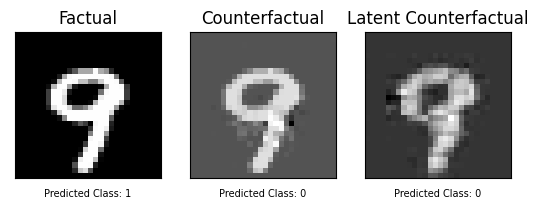

In [88]:
mosaic = """
ABC
"""
fig, axs = plt.subplot_mosaic(mosaic)
for img,ax,title in zip([factual,counterfactual,latent_counterfactual],["A","B","C"],["Factual","Counterfactual","Latent Counterfactual"]):
    axs[ax].imshow(img.detach().view(28, 28), cmap='gray', interpolation='none')
    predicted_class = torch.argmax(model(img.detach()), dim=1).item()
    axs[ax].set_xlabel(f"Predicted Class: {predicted_class}",fontsize=7)
    axs[ax].set_title(title)
    axs[ax].set_xticks([])
    axs[ax].set_yticks([])
plt.show()

# Measuring robustness

In [94]:
# GIVEN A COUNTERFACTUAL EVALUATE ITS ROBUSTNESS

latent_robustness,std_robustness = [],[]
for radius in np.linspace(0.01,0.3,100):
    #robustness of standard counterfactual
    std_recourse = gator.recourse_invalidation(
        model, #classification model
        factual, # factual data. assumed traget is 1
        counterfactual.detach(), # counter factual to evaluate robustness
        sigma2=radius, # neighbourbhood radius
        device="cpu",
        n_samples=500
    )
    std_robustness.append(std_recourse.item())
    
    
    #robustness of latent counterfactual
    latent_recourse = gator.recourse_invalidation(
        model, #classification model
        factual, # factual data. assumed traget is 1
        latent_counterfactual.detach(), # counter factual to evaluate robustness
        sigma2=radius, # neighbourbhood radius
        device="cpu",
        n_samples=500
    )
    latent_robustness.append(latent_recourse.item())

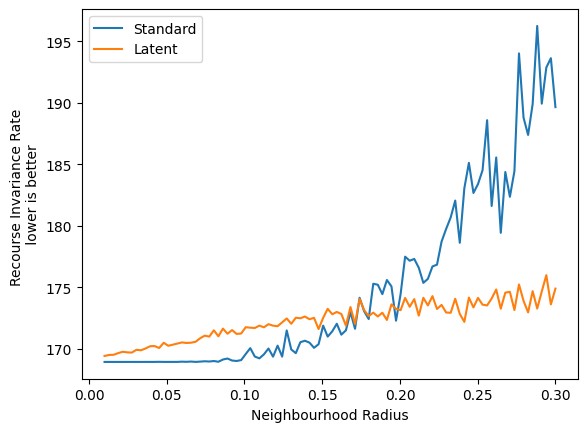

In [95]:
plt.plot(np.linspace(0.01,0.3,100),std_robustness,label="Standard")
plt.plot(np.linspace(0.01,0.3,100),latent_robustness,label="Latent")
plt.ylabel("Recourse Invariance Rate \n lower is better ")
plt.xlabel("Neighbourhood Radius")
plt.legend()
plt.show()